In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import torch
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

import flippers

In [3]:
# This helper loads any dataset in the wrench benchmarks
# and creates monopolar label matrices from their multipolar data
def load_wrench_dataset(dataset):
    dataset = "datasets/" + f"{dataset}" + "/{}.json"
    train = pd.read_json(dataset.format("train")).T
    dev = pd.read_json(dataset.format("valid")).T
    test = pd.read_json(dataset.format("test")).T

    L_train, polarities, polarities_mapping = flippers.multipolar_to_monopolar(
        train["weak_labels"].apply(pd.Series)
    )
    L_dev, _, _ = flippers.multipolar_to_monopolar(
        dev["weak_labels"].apply(pd.Series), polarities_mapping
    )
    L_test, _, _ = flippers.multipolar_to_monopolar(
        test["weak_labels"].apply(pd.Series), polarities_mapping
    )

    return (train, dev, test), (L_train, L_dev, L_test), polarities

Choose your dataset here

In [4]:
datasets = ["cdr", "yelp", "youtube", "census", "spouse", "basketball", "sms", "tennis"]
dataset = "youtube"
data, weak_labels, polarities = load_wrench_dataset(dataset)
train, dev, test = data
L_train, L_dev, L_test = weak_labels

C:\Users\liamt\Repos\flippers\flippers\_core\_core.py:132: UserWarning: Polarity mapping if not furnished.
Make sure L captures all possible values of each weak labelers.
  warnings.warn(


In [5]:
class_balances = list(
    dev["label"].astype(int).value_counts(normalize=True).sort_index()
)
class_balances

[0.5333333333333333, 0.4666666666666667]

In [6]:
L_train0, L_test0 = L_train.copy(), L_test.copy()

In [7]:
text = pd.DataFrame.from_dict(train["data"].tolist())

In [8]:
sentences = list(text["text"])
sentences[:5]

['pls http://www10.vakinha.com.br/VaquinhaE.aspx?e=313327 help me get vip gun  cross fire al\ufeff',
 'if your like drones, plz subscribe to Kamal Tayara. He takes videos with  his drone that are absolutely beautiful.\ufeff',
 'go here to check the views :3\ufeff',
 'Came here to check the views, goodbye.\ufeff',
 'i am 2,126,492,636 viewer :D\ufeff']

In [9]:
def clean(sentences):
    # Remove Nones for sentences
    sentences = ["None" if doc is None else doc for doc in sentences]

    import re

    for i, sentence in enumerate(sentences):
        sentences[i] = sentences[i].replace("\ufeff", "")

    # Define regular expression pattern for links
    link_pattern = re.compile(r"http\S+")

    # Replace links with 'http' in each sentence
    for i, sentence in enumerate(sentences):
        sentences[i] = re.sub(link_pattern, "http", sentence)

    # Define regular expression pattern for emojis
    emoji_pattern = re.compile("[" "\U0001F600-\U0001F64F" "]+", flags=re.UNICODE)

    # Replace emojis in each sentence
    for i, sentence in enumerate(sentences):
        sentences[i] = re.sub(emoji_pattern, "emoji", sentence)

    # Define regular expression pattern for special characters and Unicode
    special_pattern = re.compile(r"[^a-zA-Z0-9\s.,:!?;]")

    for i, sentence in enumerate(sentences):
        sentences[i] = re.sub(special_pattern, " ", sentence)

    # Punctuation
    punctuation = re.compile(r"[^\w\s]|_")

    for i, sentence in enumerate(sentences):
        sentences[i] = re.sub(punctuation, " ", sentence)

    # Small words
    small_words = re.compile(r"\b\w{1,3}\b")
    for i, sentence in enumerate(sentences):
        sentences[i] = re.sub(small_words, " ", sentence)

    sentences = ["None" if doc is None else doc for doc in sentences]
    sentences = [x.lower() for x in sentences]
    return sentences

In [10]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
len(sentences)

1586

In [13]:
sentences = clean(sentences)
sentences = list(set(sentences))
# Preprocess the documents using TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(sentences)

# Perform C-means clustering
num_topics = 10  # Specify the number of clusters
model = KMeans(n_clusters=num_topics, init="k-means++", max_iter=100, n_init=1)
model.fit(X)

# Print the clusters
for i in range(num_topics):
    print(f"Cluster {i}:")
    k = 0
    for j in range(len(sentences)):
        if (model.labels_[j] == i) and k < 10:
            print(sentences[j])
            k += 1
    print("\n")

Cluster 0:
check   this playlist   youtube                                                                                       
youtube money                        
check     playlist
check   this video   youtube           
check   this video   youtube               
check   this video   youtube 
check   this video   youtube     href  http     eminem   rihanna   love        
  guys check   youtube channel
check   this video   youtube facebook lhudygirlamaya 
check   this video   youtube                     


Cluster 1:
  love eminem      
  love song   
love your song makes   happy
check     cover   love         please  
love
love this song makes   wanna dance  
  love katty perry
    funny love  
eminem   love              
  love this song   


Cluster 2:
subscribe   please
subscribe pleaaaase     instagram account       subscribe back    http
subscribe     channel people   
please subscribe     channel  
come subscribe
  guys subscribe     channel     reason  please   
everyday 

In [14]:
def get_topics(df):
    text = pd.DataFrame.from_dict(df["data"].tolist())
    sentences = list(text["text"])
    topic = model.predict(vectorizer.transform(clean(sentences)))
    # Create a new dataframe with columns for all possible values
    L_topic = pd.DataFrame(columns=[f"topic_{i}" for i in range(num_topics)])
    # Set the values in each row based on the original column
    for i, t in enumerate(list(topic)):
        L_topic.loc[i, f"topic_{t}"] = 1
    L_topic = L_topic.fillna(0)
    return L_topic

In [15]:
L_train_topics = get_topics(train)
L_test_topics = get_topics(test)

In [16]:
L_train

,0,1,2,3,4,5,6,7,8,9
0,0,0,1,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1581,1,0,0,0,0,1,0,0,0,0
1582,0,0,0,0,0,0,0,0,0,1
1583,1,1,0,0,0,1,0,0,0,1
1584,0,1,0,0,0,1,0,0,0,1


In [17]:
L_train = pd.concat(
    [L_train0.reset_index(drop=True), L_train_topics.reset_index(drop=True)], axis=1
)
L_test = pd.concat(
    [L_test0.reset_index(drop=True), L_test_topics.reset_index(drop=True)], axis=1
)

In [18]:
# L_train = L_train_topics
# L_test = L_test_topics

In [25]:
L_train

,0,1,2,3,4,5,6,7,8,9,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1581,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1582,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1583,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1584,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [19]:
y_test = test["label"].astype(int).values

In [20]:
Metrics = {}


def score(
    model,
    L=L_test,
    y_true=y_test,
    boxplots=True,
    fill_proba=False,
    name="",
    predict_proba_args={},
):
    y_pred = model.predict_proba(L, *predict_proba_args)[:, 1]

    def fill_proba(proba):
        proba = proba.copy()
        proba[L.sum(axis=1) == 0] = class_balances[1]
        return proba

    if fill_proba:
        y_pred = fill_proba(y_pred)

    AP = metrics.average_precision_score(y_true, y_pred)
    F1 = metrics.f1_score(y_true, y_pred.round())
    AUC = metrics.roc_auc_score(y_true, y_pred)
    Accuracy = metrics.accuracy_score(y_true, y_pred.round())
    Balanced_Accuracy = metrics.balanced_accuracy_score(y_true, y_pred.round())
    M = {
        "F1": F1,
        "Average_Precision": AP,
        "AUC": AUC,
        "Accuracy": Accuracy,
        "Balanced_Accuracy": Balanced_Accuracy,
    }
    for key in M:
        M[key] = round(M[key], 3)

    if boxplots:
        fig, axs = plt.subplots(1, 2, figsize=(8, 3))
        plt.title(name)
        pd.DataFrame({"y_pred": y_pred, "y_true": y_true}).boxplot(
            by="y_true", ax=axs[0]
        )
        axs[0].set_title("Predicted probabilities grouped by ground truth")
        axs[0].set_ylim([0, 1])
        axs[0].get_figure().suptitle("")
        plt.ylabel("y_pred")

        pd.Series(y_pred).plot.box(ax=axs[1])
        axs[1].set_title("Predicted probabilties")
        axs[1].set_ylim([0, 1])
        axs[1].axhline(
            y_true.mean(), color="g", linestyle="--", alpha=0.3, label="Mean of y_true"
        )

        # Add a cross indicating the mean of y_pred
        mean_y_pred = pd.Series(y_pred).mean()
        axs[1].scatter(
            [1], [mean_y_pred], marker="+", color="r", s=200, label="Mean of y_pred"
        )
        axs[1].legend()

        plt.ylabel("y_pred")
        plt.tight_layout()
        plt.show()
    if name:
        global Metrics
        Metrics[name] = M
    return M

In [21]:
from flippers.models import SnorkelModel

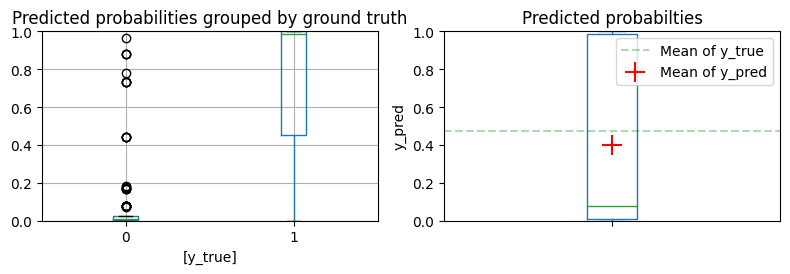

{'F1': 0.813,
 'Average_Precision': 0.925,
 'AUC': 0.914,
 'Accuracy': 0.84,
 'Balanced_Accuracy': 0.835}

In [35]:
topics_polarities = np.ones(num_topics)
# topics_polarities[[0,4]] = 0
m = SnorkelModel(
    np.concatenate((polarities, topics_polarities), axis=0),
    # topics_polarities,
    class_balances=class_balances,
    cardinality=2,
)
m.fit(L_train, learning_rate=1e-3, k=1e-2, num_epochs=5, device="cuda")

# This is the Uniform Marginals calculation the Snorkel and Metal libraries use
# Performance should be very similar to the Snorkel model
score(m, name="flippers")

<Axes: >

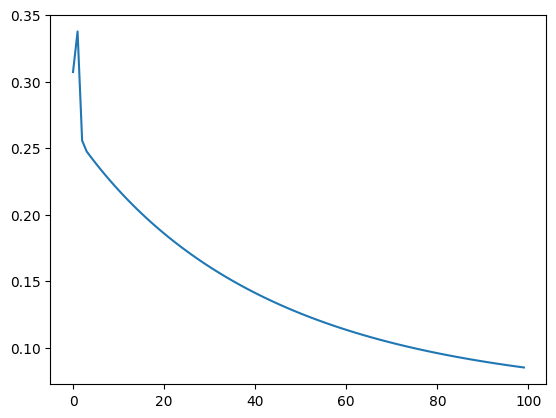

In [23]:
pd.Series(m.loss_history).plot()

In [24]:
m.mu

Parameter containing:
tensor([[0.0987, 0.3125],
        [0.0536, 0.2006],
        [0.0504, 0.1536],
        [0.0383, 0.2053],
        [0.2225, 0.0457],
        [0.0472, 0.3700],
        [0.3121, 0.0525],
        [0.1182, 0.0223],
        [0.0640, 0.0075],
        [0.5077, 0.1288],
        [0.0154, 0.1851],
        [0.0514, 0.0577],
        [0.0201, 0.0867],
        [0.0062, 0.0132],
        [0.6180, 0.4434],
        [0.0513, 0.1525],
        [0.0402, 0.0711],
        [0.0166, 0.0415],
        [0.0547, 0.2256],
        [0.0398, 0.0584]], requires_grad=True)